# First: load imports needed for the project and preparation of the project

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 167 (delta 103), reused 26 (delta 12), pack-reused 0
Receiving objects: 100% (167/167), 3.69 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.5
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [7]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [8]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [9]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [10]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [11]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very dofferent. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [32]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_scaled = df.copy()
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_scaled.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [34]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 819.95it/s]


In [35]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1189.55it/s]


In [36]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1071.62it/s]


In [37]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [38]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [39]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval outside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [54]:
batches_whole = utils_bsc.create_batches(dataset_clean, 30)
batches_whole_norm = utils_bsc.create_batches(dataset_norm, 30)

print(f'\nWhole dataset: {len(batches_whole)} pairs of sequences of longitud {batches_whole[0].shape[1]} with {batches_whole[0].shape[2]} features')
print(f'Whole dataset Normalised: {len(batches_whole_norm)} pairs of sequences of longitud {batches_whole_norm[0].shape[1]} with {batches_whole_norm[0].shape[2]} features')


100%|██████████| 63330/63330 [00:10<00:00, 6049.84it/s]


(63329, 2, 30, 18)

Whole dataset: 63329 pairs of sequences of longitud 30 with 18 features
Whole dataset Normalised: 63329 pairs of sequences of longitud 30 with 18 features


In [104]:
print(batches_whole_norm.shape)
print(type(batches_whole_norm))
print(type(batches_whole_norm[0]))
print(type(batches_whole_norm[0][0][0]))
for i in batches_whole_norm[0][0][0]:
  print(type(i))

(63329, 2, 30, 18)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [119]:
# Spliting into train and test sets and convert into pytorch tensors with the normalised data


training_data_whole_norm, testing_data_whole_norm = train_test_split(batches_whole_norm, test_size=0.1, random_state=25)

print(type(training_data_whole_norm))
print(training_data_whole_norm.shape)
print(type(training_data_whole_norm[0]))
print(training_data_whole_norm[0].shape)
print(type(training_data_whole_norm[0][0]))
print(training_data_whole_norm[0][0].shape)
print(type(training_data_whole_norm[0][0][0]))
print(training_data_whole_norm[0][0][0].shape)
print(training_data_whole_norm[0][0][0])

training_data_whole_norm = torch.from_numpy(training_data_whole_norm).float().to(device)
testing_data_whole_norm = torch.from_numpy(testing_data_whole_norm).float().to(device)

print(f'length of training set (whole dataset): {training_data_whole.shape[0]}')
print(f'length of test set (whole dataset): {testing_data_whole.shape[0]}')
print('\n')

<class 'numpy.ndarray'>
(56996, 2, 30, 18)
<class 'numpy.ndarray'>
(2, 30, 18)
<class 'numpy.ndarray'>
(30, 18)
<class 'numpy.ndarray'>
(18,)
[ 0.93692739  0.66488652  0.73407013 -1.02309578 -0.94027917 -1.06852472
  0.84702147  0.65598575  0.80809456  1.20410812  0.67898539 -0.08118725
 -0.25362287 -0.3452846  -0.46933621  0.05300223 -0.15610002 -0.51219082]


NameError: ignored

In [125]:
# Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
# When you plug in one measure, the model should out the next measure

pair_set = []

for i in tqdm(range(len(dataset_norm) -1)):
  data = np.array([j for j in dataset_norm.iloc[i, 1:]])
  target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
  
  pair_set.append((data, target))

dataset_pairs = np.array(pair_set)

100%|██████████| 63359/63359 [00:22<00:00, 2839.96it/s]


In [142]:
training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

data = []
target = []
for i in training_data_pairs:
  data.append(i[0])
  target.append(i[1])

training_data = torch.from_numpy(np.array(data)).float().to(device)
training_target = torch.from_numpy(np.array(target)).float().to(device)

data = []
target = []
for i in testing_data_pairs:
  data.append(i[0])
  target.append(i[1])

test_data = torch.from_numpy(np.array(data)).float().to(device)
test_target = torch.from_numpy(np.array(target)).float().to(device)

print(f'length of training set (whole dataset): {training_data.shape[0]}')
print(f'length of test set (whole dataset): {test_data.shape[0]}')
print('\n')

length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [144]:
criterion = nn.MSELoss()

losses_train = []

for i in range(1, len(training_data_whole_norm)):
  output = training_data[i]
  target = training_target[i]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in range(1, len(testing_data_pairs)):
  output = test_data[i]
  target = test_target[i]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4737651490329326
Standard deviation Loss of baselinemodel:  0.7239740402432294


Test set
Mean Loss of baselinemodel:  0.4659431133047794
Standard deviation Loss of baselinemodel:  0.6987633647386906




# Train a simple Feed Forward Neural Network

I trained a simple FFN Network to have a second baseline model. The final model training should have also a better performance than this FFN.

In [146]:
# Create data loader to feed the FFN in mini batches

loader_train = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(training_data, training_target),
    batch_size=64,
    shuffle=True
)

# Create data loader for testing the model
loader_test = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(test_data, test_target),
    batch_size=64,
    shuffle=True
)

In [ ]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 180)
        self.linear3 = nn.Linear(20, D_out)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        return self.linear3(x)

# This function trains the model for one epoch
def train(model, device, train_set, optimizer, n_epochs):

    epoch_loss = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      losses = []

      print('Train')
      model.train()
      for batch_idx in tqdm(range(len(train_set))):
        
        batch = train_set[batch_idx]

        for i in range(len(batch) - 1):

          data, target = batch[i].to(device), batch[i + 1].to(device)

          optimizer.zero_grad()

          # Forward Pass
          output = model(data)

          #Compute loss
          loss = criterion(output, target)

          #Backpropagation
          loss.backward()

          #Optimization
          optimizer.step()


      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for batch_idx in tqdm(range(len(train_set))):
          batch = train_set[batch_idx]

          for i in range(len(batch) - 1):

            data, target = batch[i].to(device), batch[i + 1].to(device)

            output = model(data)
              
            losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss.append(losses)

    return model, epoch_loss

n_epochs = 4
lr=0.001

# Define Loss, Optimizer
criterion = nn.MSELoss()

train_FFN = True
if train_FFN is True:
  print('Whole Dataset:')
  model_FFN_whole = ANN_relu(18, 18).to(device)
  optimizer = torch.optim.SGD(model_FFN_whole.parameters(), lr=lr)
  trained_model3 , whole_set_losses = train(model_FFN_whole, device, training_data_whole_norm, optimizer, n_epochs)
  print('\n')

Weekday Dataset:

Epoch 1:
Train


100%|██████████| 25976/25976 [09:29<00:00, 45.65it/s]



Test with training set


100%|██████████| 25976/25976 [02:08<00:00, 201.38it/s]



Current loss:  0.30983840211929425

Epoch 2:
Train


100%|██████████| 25976/25976 [09:23<00:00, 46.08it/s]



Test with training set


100%|██████████| 25976/25976 [02:10<00:00, 199.73it/s]



Current loss:  0.3087435358885242

Epoch 3:
Train


100%|██████████| 25976/25976 [09:22<00:00, 46.17it/s]



Test with training set


100%|██████████| 25976/25976 [02:09<00:00, 200.67it/s]



Current loss:  0.30808435389590766

Epoch 4:
Train


100%|██████████| 25976/25976 [09:22<00:00, 46.22it/s]



Test with training set


100%|██████████| 25976/25976 [02:09<00:00, 200.63it/s]



Current loss:  0.3069355035234076


Weekend Dataset:

Epoch 1:
Train


100%|██████████| 28294/28294 [10:14<00:00, 46.06it/s]



Test with training set


100%|██████████| 28294/28294 [02:21<00:00, 200.51it/s]



Current loss:  0.46093833830883485

Epoch 2:
Train


100%|██████████| 28294/28294 [10:45<00:00, 43.84it/s]



Test with training set


100%|██████████| 28294/28294 [02:23<00:00, 197.06it/s]



Current loss:  0.45740237129269457

Epoch 3:
Train


100%|██████████| 28294/28294 [10:15<00:00, 45.95it/s]



Test with training set


100%|██████████| 28294/28294 [02:21<00:00, 200.04it/s]



Current loss:  0.455178074687676

Epoch 4:
Train


100%|██████████| 28294/28294 [10:15<00:00, 45.97it/s]



Test with training set


100%|██████████| 28294/28294 [02:21<00:00, 199.69it/s]



Current loss:  0.45328326599206925


Whole Dataset:

Epoch 1:
Train


100%|██████████| 56997/56997 [20:27<00:00, 46.42it/s]



Test with training set


100%|██████████| 56997/56997 [04:42<00:00, 201.66it/s]



Current loss:  0.2979278438075961

Epoch 2:
Train


100%|██████████| 56997/56997 [20:34<00:00, 46.16it/s]



Test with training set


100%|██████████| 56997/56997 [04:43<00:00, 200.82it/s]



Current loss:  0.2953299432862701

Epoch 3:
Train


100%|██████████| 56997/56997 [20:36<00:00, 46.08it/s]



Test with training set


100%|██████████| 56997/56997 [04:44<00:00, 200.07it/s]



Current loss:  0.2940153248391583

Epoch 4:
Train


100%|██████████| 56997/56997 [20:33<00:00, 46.21it/s]



Test with training set


100%|██████████| 56997/56997 [04:43<00:00, 200.87it/s]



Current loss:  0.2933188504910381




In [ ]:
# This function Test the model with the test set
def test(model, test_set):

  criterion = nn.MSELoss()

  print('\nTest with Test set')
  model.eval()
  with torch.no_grad():
    for batch_idx in tqdm(range(len(test_set))):
      batch = test_set[batch_idx]

      for i in range(len(batch) - 1):

        data, target = batch[i].to(device), batch[i + 1].to(device)

        output = model(data)
          
        losses.append (float(criterion(output, target).item()))

    print('\nMean Loss in Test set: ', np.mean(losses))

print('Weekday Dataset:')
test(trained_model1, testing_data_weekday_norm)
print('\n')

print('Weekend Dataset:')
test(trained_model2, testing_data_weekend_norm)
print('\n')

print('Whole Dataset:')
test(trained_model3, testing_data_whole_norm)
print('\n')

Weekday Dataset:

Test with Test set


100%|██████████| 2887/2887 [00:14<00:00, 201.16it/s]



Mean Loss in Test set:  0.6996191194919645


Weekend Dataset:

Test with Test set


100%|██████████| 3144/3144 [00:15<00:00, 200.73it/s]



Mean Loss in Test set:  0.5895734702318555


Weekday Dataset:

Test with Test set


100%|██████████| 6333/6333 [00:31<00:00, 198.63it/s]


Mean Loss in Test set:  0.4478775834217984




The last basemodel i am going to use is a simple RNN. The final model should also have a better performance than this RNN.

# RNN Model

We train before a standard RNN and see which results we can expected with a small and easy solution.
I am using this template (https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb) and make changes using it as a base.

1) torch.nn.RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Parameters
* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
* nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
* bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
* dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
* bidirectional – If True, becomes a bidirectional RNN. Default: False

2) torch.nn.Linear (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Parameters
* in_features – size of each input sample
* out_features – size of each output sample
* bias – If set to False, the layer will not learn an additive bias. Default: True


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device, batch_first = True, dropout = 0):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_dim, num_layers = n_layers, batch_first = batch_first, dropout = dropout)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size).to(self.device)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        out = torch.relu(out)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [ ]:
def train_RNN(model, criterion, optimizer, train_set, test_set):

  epoch_loss_train = []
  epoch_loss_test = []

  # Training Run
  for epoch in range(1, n_epochs + 1):

    print(f'Epoch {epoch}')

    losses_train = []
    losses_test = []

    model.train()

    optimizer.zero_grad() # Clears existing gradients from previous epoch

    print('\nTraining:')
    for i in tqdm(range(len(train_set))):

      input = train_set[i][0]

      target = train_set[i][1]

      output, hidden = model_rnn(input.unsqueeze(0))

      #Compute loss
      loss = criterion(output, target)

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()

    print('\nTest with training set')
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(train_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        output, hidden = model(input.unsqueeze(0))

        #Compute loss
        losses_train.append (float(criterion(output, target).item()))

    print('\nTest with test set')
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(test_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        output, hidden = model(input.unsqueeze(0))

        #Compute loss
        losses_test.append (float(criterion(output, target).item()))


    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return epoch_loss_train, epoch_loss_test, model

In [ ]:
# Instantiate the model with hyperparameters
model_rnn = RNN(input_size = 18,
                output_size = 18,
                hidden_dim = 36,
                n_layers = 1,
                batch_first = True,
                dropout = 0,
                device = device)

# We'll also set the model to the device that we defined earlier (default is CPU)
model_rnn = model_rnn.to(device)

# Define hyperparameters
n_epochs = 4
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

train_set = training_data_pairs
test_set = testing_data_pairs

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [ ]:
def positional_encoding(seq_len: int, dim_model: int, device):
    
    # Tensor with the positions of every sequence element (0 to seq_len)
    pos = torch.arange(seq_len, dtype=float32, device=device).reshape(1, -1, 1)
    
    # Tensor with the positions of every feature in the sequence (0 to dim_model)
    dim = torch.arange(dim_model, dtype=float32, device=device).reshape(1, 1, -1)

    phase = pos / (1e4 ** (torch.div(dim, dim_model, rounding_mode='floor')))

    position_encoding = torch.where(dim.long() % 2 == 0, sin(phase), cos(phase))

    return position_encoding.to(device)


class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, debug: bool = False, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device
        self.debug = debug

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)
        
    def forward (self, src):
        
        mask = self.generate_square_mask(len(src))
        if self.debug is True:
            print('mask creation: ok')

        src_pos = src + positional_encoding(src.shape[1], src.shape[2], self.device)
        if self.debug is True:
            print('Pos encoder (encoder): ok')

        output = self.encoder (src, mask)
        if self.debug is True:
            print('encoder pass: ok')
        
        output = self.decoder (src_pos, output, mask)
        if self.debug is True:
            print('decoder pass: ok')
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [ ]:
# Initialize Transformer Model and Optimizer

model = Transformer (num_encoder_layers=3,
                     num_decoder_layers=3,
                     feature_size=18,
                     output_size=18,
                     num_heads=3,
                     device = device,
                     batch_first=False,
                     debug=False)


train_set = training_data_pairs
test_set = testing_data_pairs

print('Setup model Ok')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

epoch_loss_train = []
epoch_loss_test = []

train_transformer = True

if train_transformer is True:

  # Lists to keep track of the losses
  loss_list_train = []
  loss_list_test = []

  n_epochs = 4

  for e in range(1, n_epochs + 1):
    print('Epoch: ', e)

    print('Training:')
    model.train()
    # Initialize optimizer gradients
    optimizer.zero_grad()

    for i in tqdm(range(len(train_set))):

      input = train_set[i][0]

      target = train_set[i][1]

      net_out = model.forward(input.unsqueeze(0))

      #Compute loss
      loss = criterion(net_out, target.unsqueeze(0))

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(train_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        net_out = model.forward(input.unsqueeze(0))

        #Compute loss
        losses_train.append (float(criterion(net_out, target.unsqueeze(0)).item()))


    print('\nTest with training set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(range(len(test_set))):
        input = train_set[i][0]
        target = train_set[i][1]

        net_out = model.forward(input.unsqueeze(0))

        #Compute loss
        losses_test.append (float(criterion(net_out, target.unsqueeze(0)).item()))

    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

Setup model Ok
Setup optimizer Ok
Epoch:  1
Training:


100%|██████████| 56996/56996 [22:57<00:00, 41.39it/s]



Test with training set


100%|██████████| 56996/56996 [05:35<00:00, 169.71it/s]



Test with training set


100%|██████████| 6333/6333 [00:37<00:00, 169.22it/s]



Current Mean loss Train Set:  17.8081452231113

Current Mean loss Test Set:  17.808013503253694


Epoch:  2
Training:


100%|██████████| 56996/56996 [22:41<00:00, 41.87it/s]



Test with training set


100%|██████████| 56996/56996 [05:36<00:00, 169.24it/s]



Test with training set


100%|██████████| 6333/6333 [00:37<00:00, 168.93it/s]



Current Mean loss Train Set:  20.689044967284328

Current Mean loss Test Set:  20.689511593533


Epoch:  3
Training:


100%|██████████| 56996/56996 [22:30<00:00, 42.19it/s]



Test with training set


100%|██████████| 56996/56996 [05:34<00:00, 170.51it/s]



Test with training set


100%|██████████| 6333/6333 [00:36<00:00, 171.82it/s]



Current Mean loss Train Set:  17.399096156414856

Current Mean loss Test Set:  17.37718508319984


Epoch:  4
Training:


100%|██████████| 56996/56996 [22:27<00:00, 42.31it/s]



Test with training set


100%|██████████| 56996/56996 [05:32<00:00, 171.35it/s]



Test with training set


100%|██████████| 6333/6333 [00:36<00:00, 172.01it/s]


Current Mean loss Train Set:  9.250140273476477

Current Mean loss Test Set:  9.267819709392327




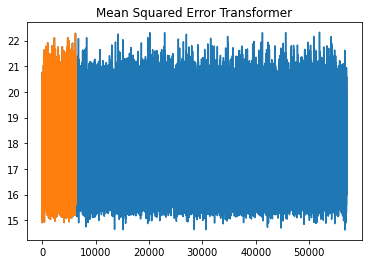

In [ ]:
# Show results of the loss function

fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

ax.plot([np.mean(i) for i in epoch_loss_train])
ax.plot([np.mean(i) for i in epoch_loss_test])
ax.set_title("Mean Squared Error Transformer")
fig.canvas.draw()

Ideas, things to remember, to search, etc...

reconstruction, vergelich mit base line model